In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import pandas as pd
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import neighbors, datasets
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.spatial import ConvexHull
from tqdm import tqdm
import random
plt.style.use('ggplot')
import pickle
from sklearn import tree
from sklearn.tree import export_graphviz
from joblib import dump, load
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
%matplotlib inline

In [2]:
def getAuc(X,y,test_size=0.25,max_depth=None,n_estimators=100,
           minsplit=4,FPR=[],TPR=[],VERBOSE=False, USE_ONLY=None):
    '''
        get AUC given training data X, with target labels y
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    CLASSIFIERS=[DecisionTreeClassifier(max_depth=max_depth, min_samples_split=minsplit),
                RandomForestClassifier(n_estimators=n_estimators,
                                       max_depth=max_depth,min_samples_split=minsplit),
                ExtraTreesClassifier(n_estimators=n_estimators,
                                     max_depth=max_depth,min_samples_split=minsplit),
                AdaBoostClassifier(n_estimators=n_estimators),
                GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth),
                svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced',probability=True)]

    if USE_ONLY is not None:
        if isinstance(USE_ONLY, (list,)):
            CLASSIFIERS=[CLASSIFIERS[i] for i in USE_ONLY]
        if isinstance(USE_ONLY, (int,)):
            CLASSIFIERS=CLASSIFIERS[USE_ONLY]

    for clf in CLASSIFIERS:
        clf.fit(X_train,y_train)
        y_pred=clf.predict_proba(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
        auc=metrics.auc(fpr, tpr)
        if VERBOSE:
            print(auc)

        FPR=np.append(FPR,fpr)
        TPR=np.append(TPR,tpr)
    points=np.array([[a[0],a[1]] for a in zip(FPR,TPR)])
    hull = ConvexHull(points)
    x=np.argsort(points[hull.vertices,:][:,0])
    auc=metrics.auc(points[hull.vertices,:][x,0],points[hull.vertices,:][x,1])
    return auc,CLASSIFIERS

In [3]:
def getConfusion(X,y,test_size=0.25,max_depth=None,n_estimators=100,
           minsplit=4,CONFUSION={},VERBOSE=False, USE_ONLY=None,target_names = None):
    '''
        get AUC given training data X, with target labels y
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    CLASSIFIERS=[DecisionTreeClassifier(max_depth=max_depth, min_samples_split=minsplit),
                RandomForestClassifier(n_estimators=n_estimators,class_weight='balanced',
                                       max_depth=max_depth,min_samples_split=minsplit),
                ExtraTreesClassifier(n_estimators=n_estimators,class_weight='balanced',
                                     max_depth=max_depth,min_samples_split=minsplit),
                AdaBoostClassifier(n_estimators=n_estimators),
                GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth),
                svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced',probability=True)]

    if USE_ONLY is not None:
        if isinstance(USE_ONLY, (list,)):
            CLASSIFIERS=[CLASSIFIERS[i] for i in USE_ONLY]
        if isinstance(USE_ONLY, (int,)):
            CLASSIFIERS=CLASSIFIERS[USE_ONLY]

    for clf in CLASSIFIERS:
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
        #print(y_test,y_pred)
        cmat=confusion_matrix(y_test, y_pred)
        acc=accuracy_score(y_test, y_pred)
        
        CONFUSION[clf]=cmat
        
        if VERBOSE:
            print(classification_report(y_test, y_pred, target_names=target_names))
            print('Confusion MAtrix:\n', cmat)
            print(' ')
            print('Accuracy:', acc)

        
    return CONFUSION,acc

In [8]:
df=pd.read_csv('psychoByDiag.csv',index_col=0,sep=',')

In [9]:
df

,DX,Primary,Positive,Negative,Cognitive,Mania
ID,,,,,,
1,1,-0.876,1.141,0.660,0.917,1.263
2,1,-1.092,-1.254,0.599,1.200,2.024
3,1,-1.004,-0.700,0.761,1.051,-0.320
4,1,-0.993,-0.592,0.522,0.830,-0.322
5,3,-0.868,-1.124,0.082,-0.503,-0.350
...,...,...,...,...,...,...
645,1,0.934,-0.518,-0.319,-0.315,0.877
646,2,1.466,-0.290,-0.278,-1.275,2.196
647,1,-0.163,0.366,0.155,0.470,-0.169


In [15]:
df=df[df['DX']>0]
X=df.iloc[:,1:].values
y=df.iloc[:,0].values.astype(str)

In [17]:
X

array([[-0.876,  1.141,  0.66 ,  0.917,  1.263],
       [-1.092, -1.254,  0.599,  1.2  ,  2.024],
       [-1.004, -0.7  ,  0.761,  1.051, -0.32 ],
       ...,
       [-0.163,  0.366,  0.155,  0.47 , -0.169],
       [ 1.292,  0.982,  0.263, -0.589,  1.143],
       [ 0.269,  0.72 , -0.181, -0.184,  0.689]])

100%|██████████| 500/500 [00:03<00:00, 150.49it/s]


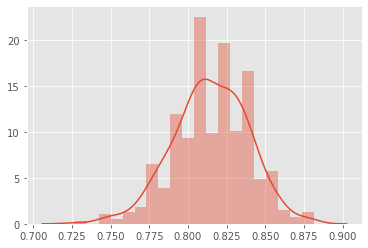

In [24]:
ACC=[]
for run in tqdm(np.arange(500)):
    CONF,acc=getConfusion(X,y,test_size=0.3,max_depth=None,n_estimators=2,
               minsplit=4,VERBOSE=False, USE_ONLY=[1],target_names=['schizophrenic',
                                                                   'schizoaffective',
                                                                   'depressed',
                                                                   'bipolar'])
    ACC=np.append(ACC,acc)
    if acc > 0.85:
        CONF_=CONF
sns.distplot(ACC)

In [25]:
CONF_

{RandomForestClassifier(bootstrap=True, class_weight='balanced',
             criterion='gini', max_depth=None, max_features='auto',
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=4, min_weight_fraction_leaf=0.0,
             n_estimators=2, n_jobs=None, oob_score=False,
             random_state=None, verbose=0, warm_start=False): array([[146,   3,   5,   3],
        [ 13,   1,   1,   0],
        [ 10,   0,   6,   0],
        [  4,   0,   2,   0]]),
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
             criterion='gini', max_depth=None, max_features='auto',
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=4, min_weight_fraction_leaf=0.0,
             n_estimators=2, n_jobs=None, oob_score=False,
             random_state=None, verbose=0, warm_start=False): array

In [97]:
df=pd.read_csv('PSYCHO.DAT',header=None,index_col=0,sep='\s+')
df=df[df[1]>0]
X=df.loc[:,2:].values
y=df.loc[:,1].values.astype(str)

df=pd.read_csv('/home/ishanu/Dropbox/scratch_/Qfeatures.csv')
df=df[df.labels>0]
X1=df.drop('labels',axis=1).values
y=df.labels.values.astype(str)
X=np.c_[X,X1]
X=X1

100%|██████████| 400/400 [00:02<00:00, 175.91it/s]


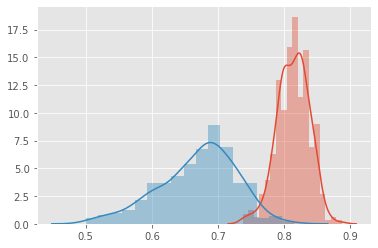

In [106]:
qACC=[]
for run in tqdm(np.arange(400)):
    CONF,acc=getConfusion(X,y,test_size=0.3,max_depth=10,n_estimators=2,
               minsplit=3,VERBOSE=False, USE_ONLY=[2],target_names=['schizophrenic',
                                                                   'schizoaffective',
                                                                   'depressed',
                                                                   'bipolar'])
    qACC=np.append(qACC,acc)

ax=sns.distplot(ACC)
sns.distplot(qACC,ax=ax)


In [91]:
CONF

{RandomForestClassifier(bootstrap=True, class_weight='balanced',
             criterion='gini', max_depth=3, max_features='auto',
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=4, min_weight_fraction_leaf=0.0,
             n_estimators=2, n_jobs=None, oob_score=False,
             random_state=None, verbose=0, warm_start=False): array([[189,  73,  54,   4],
        [ 12,   8,   7,   0],
        [  9,   1,  20,   0],
        [  4,   0,   3,   3]]),
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
             criterion='gini', max_depth=3, max_features='auto',
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=4, min_weight_fraction_leaf=0.0,
             n_estimators=2, n_jobs=None, oob_score=False,
             random_state=None, verbose=0, warm_start=False): array([[225